## Mapping and Geographic Investigation 

Capturing physical landscape traits in a written form is perhaps one of the oldest and most common examples
of information visualization still in use today. Geographical Information Systems (GIS) are high specialized
and complex, and made up of a myriad of unique techniques and tools. In this lecture I want to dip our toes
into this world, and show you how you can leverage geographical information to lead to insight in
computational narratives.

In [1]:
# Let's start with bringing in a few of our common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# And we'll set some matplotlib defaults. By setting these in the rcparams list we can
# be certain that our figure size will be the same throughout our investigation. When
# you do this make sure to do it at the top of your notebook before using matplotlib.
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [16.0,8.0]

In [4]:
# Let's bring in that data on my cycling
df=pd.read_csv("assets/wipeout.csv")
df.head()

,timestamp,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,speed,timestamp.1,position_lat_degrees,position_long_degrees
0,2019-11-01 20:12:03,NaN,0.00,281.6,0.000,NaN,84.0,504424439.0,-999065791.0,NaN,2019-11-01 20:12:03,42.280368,-83.740727
1,2019-11-01 20:12:04,NaN,0.00,281.6,0.000,NaN,84.0,504424439.0,-999065791.0,NaN,2019-11-01 20:12:04,42.280368,-83.740727
2,2019-11-01 20:12:07,NaN,0.00,281.6,0.000,NaN,87.0,504424439.0,-999065791.0,NaN,2019-11-01 20:12:07,42.280368,-83.740727
3,2019-11-01 20:12:08,NaN,0.32,281.6,1.036,NaN,88.0,504424447.0,-999065835.0,NaN,2019-11-01 20:12:08,42.280369,-83.740731
4,2019-11-01 20:12:10,NaN,3.30,281.8,2.976,NaN,89.0,504424476.0,-999066382.0,NaN,2019-11-01 20:12:10,42.280371,-83.740777


In [5]:
df['position_long_degrees'].max()

-83.74072722159326

Ok, so this data is made up of a latitude and longitude, a timestamp on what looks to be a second frequency
as well as measurements such as heart rate, in beats per minute, and an enhanced_altitude probably in feet,
speed, and so on. The first thing we need to consider when mapping is longitude and lattitude. Now, catographers
for thousands of years have come up with different ways to take a "mostly round" globe and turn it into a 2
dimensional rectangle, and these methods are called __projections__. If you are going to work a lot with
catography data you're undoubtedly going to have to learn some of these projections. I'm not an expert in all
the different ways mapping coordinates are stored, but even in this simple example it looks odd, why do we just
have a single number?

It turns out that this particular data source is trying to capture the maximum prescision possible in an 
unsigned integer, so we first need to convert these to more traditional decimal format. To do this you'll
need to go to the docs and identify how to do the transformation, but I'm saving you that step here because
I already know what it is.

In [6]:
# If we multiply by 180 degrees then dividing by 2 to the power of 31 we get to convert our units into
# something a bit more meaningful
df["position_lat_degrees"] = df["position_lat"] * ( 180 / 2**31 )
df["position_long_degrees"] = df["position_long"] * ( 180 / 2**31 )

# Now, it turns out we're not really done with this. You see, the earth is round(ish), but we are going to try
# and look at it on the screen which is flat(ish). Because we are going to plot on top of a two dimensional image
# we're going to want to use the Mercantor projection. I'm going to share with you the code to convert from 
# latitude in degrees to a flat Mercantor projection which
# comes courtesy of the Open Street Map effort at https://wiki.openstreetmap.org/wiki/Mercator

import math
def lat2y(a):
  return 180.0/math.pi*math.log(math.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))
df["position_lat_degrees_mercantor"]=df["position_lat_degrees"].apply(lat2y)

# And lastly, let's drop anything with missing values. This is a simplification for the moment, and might not
# be what you actually want to do in practice
df=df[['timestamp','enhanced_altitude','enhanced_speed','heart_rate','position_lat_degrees_mercantor',
       'position_long_degrees','position_lat_degrees']].dropna()
df.head()

,timestamp,enhanced_altitude,enhanced_speed,heart_rate,position_lat_degrees_mercantor,position_long_degrees,position_lat_degrees
0,2019-11-01 20:12:03,281.6,0.000,84.0,46.739975,-83.740727,42.280368
1,2019-11-01 20:12:04,281.6,0.000,84.0,46.739975,-83.740727,42.280368
2,2019-11-01 20:12:07,281.6,0.000,87.0,46.739975,-83.740727,42.280368
3,2019-11-01 20:12:08,281.6,1.036,88.0,46.739976,-83.740731,42.280369
4,2019-11-01 20:12:10,281.8,2.976,89.0,46.739979,-83.740777,42.280371


In [7]:
df['position_long_degrees'].max()

-83.74072722159326

The first approach I want to show you is probably the most simple. The gist is that we will render an image 
behind an Axes object, then just use our regular plotting on the Axes object. For this to work it means we
need an image and we need to know the coordinates of the image bounds. Then we can set the "extent", which
represents the bounds of the map. This means our image behind the Axes object will be using the same
coordinate system as the Axes object itself, and the plot will be locked.

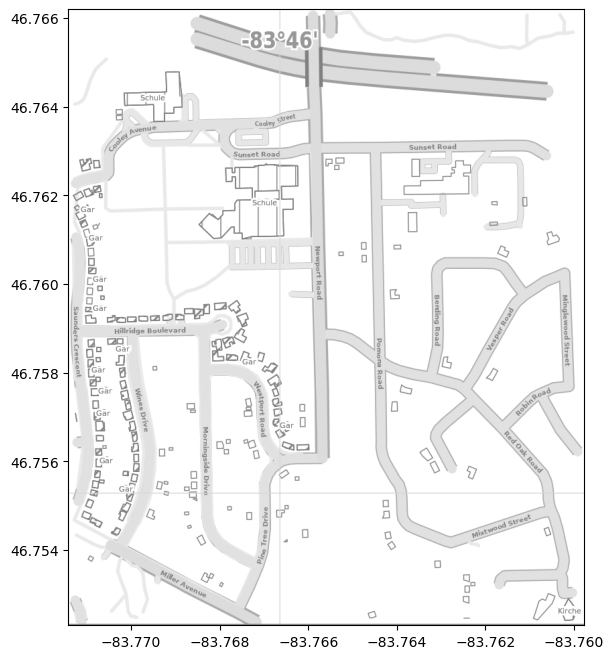

In [9]:
# First the image. I got mine through an export from Open Street Map and saved it in map.png. You can get a
# map directly from http://www.openstreetmap.org. To display this, we use the pyplot imread() function and
# pair it with imshow()
image=plt.imread("assets/map.png")
plt.imshow(image, alpha=0.5, extent=[-83.77141,-83.75977,46.75230,46.76620])

Ok, great! That created a map, and we can see the X and Y axes are constrained by the extent that I setup.
Now, the extent doesn't really matter, you can choose whatever you want, just make sure it aligns with
whatever your map is.

Now it's actually really easy to overlay our data on top of this plot, we just use whatever plotting
function which exists in pyplot that we are interested in! In this case I'm going to use scatter(). I'm
going to add a color bar as well, and change the values of the dots being plotted based on the heart rate column
in our data.

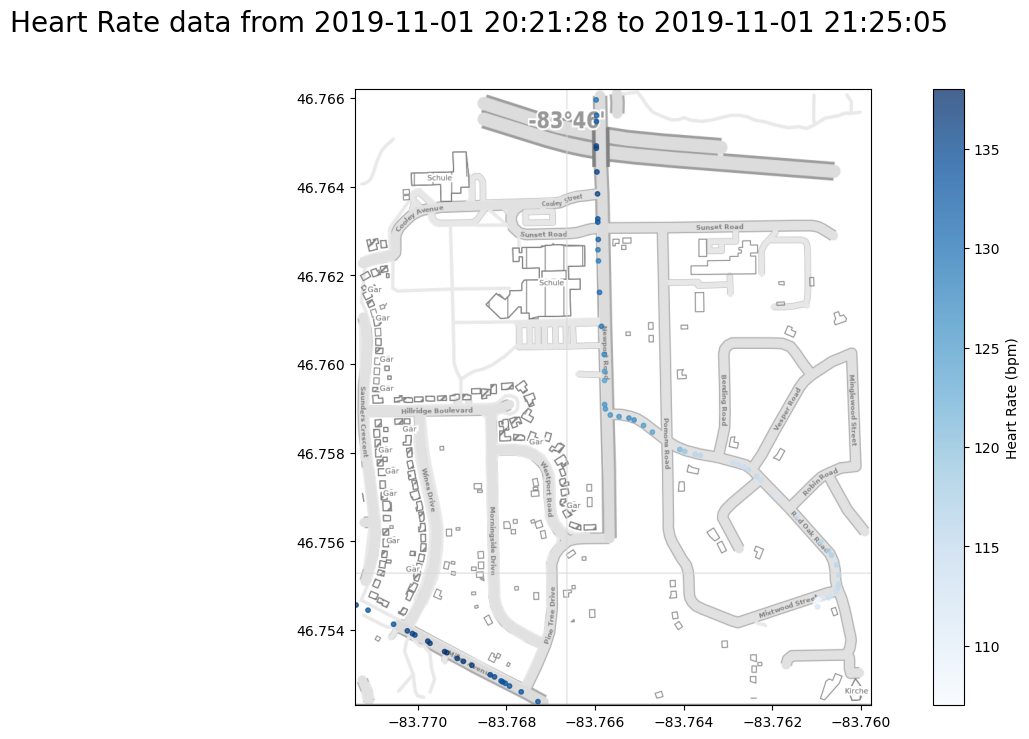

In [10]:
# Reshow the image, because we didn't turn off image closing in jupyter
plt.imshow(image, alpha=0.5, extent=[-83.77141,-83.75977,46.75230,46.76620])
# Plot our longitude and mercantor projected latitude data. We can set the series of data we want to be the
# colors of points using the c parameters, and we can choose from different color maps using the cmap
# parameter. Also, I'm only going to plot those points which actually appear on the map itself.
small_df = df[(df["position_long_degrees"] > -83.77141) &
              (df["position_long_degrees"] < -83.75977) &
              (df["position_lat_degrees_mercantor"] > 46.75230) &
              (df["position_lat_degrees_mercantor"] < 46.76620)]
   
plt.scatter(small_df["position_long_degrees"],small_df["position_lat_degrees_mercantor"],
            s=10, c=small_df["heart_rate"], cmap='Blues', alpha=0.75)
# Now we get pyplot to render a colorbar so we know the meeting of the colors
plt.colorbar().set_label("Heart Rate (bpm)")
# And let's set a meaningful title
plt.suptitle("Heart Rate data from {} to {}".format(np.min(small_df["timestamp"]),np.max(small_df["timestamp"])),size='20');

Nice! We have a map, and we have some points plotted on the map showing the various heart rate measurements! If
you look at this you'll notice that the lighter more transparent circles are closer to 100 beats per minute,
while the more dark full circles are close to 135 beats per minute. With a bit of insider knowledge - since it was
me on the bike - I can tell you that the street in the lower left corner is an up hill I would cycle and that the
street coming down from the top is actually a down hill for a return trip, so this seems to be right.

Now, this method of creating a map using an image with extents is simple and reliable, though it's not fast or seemless. 
If we just tossed our full dataframe on there it would become aparent that we need to go find a map 
with the right extents to do the plotting.

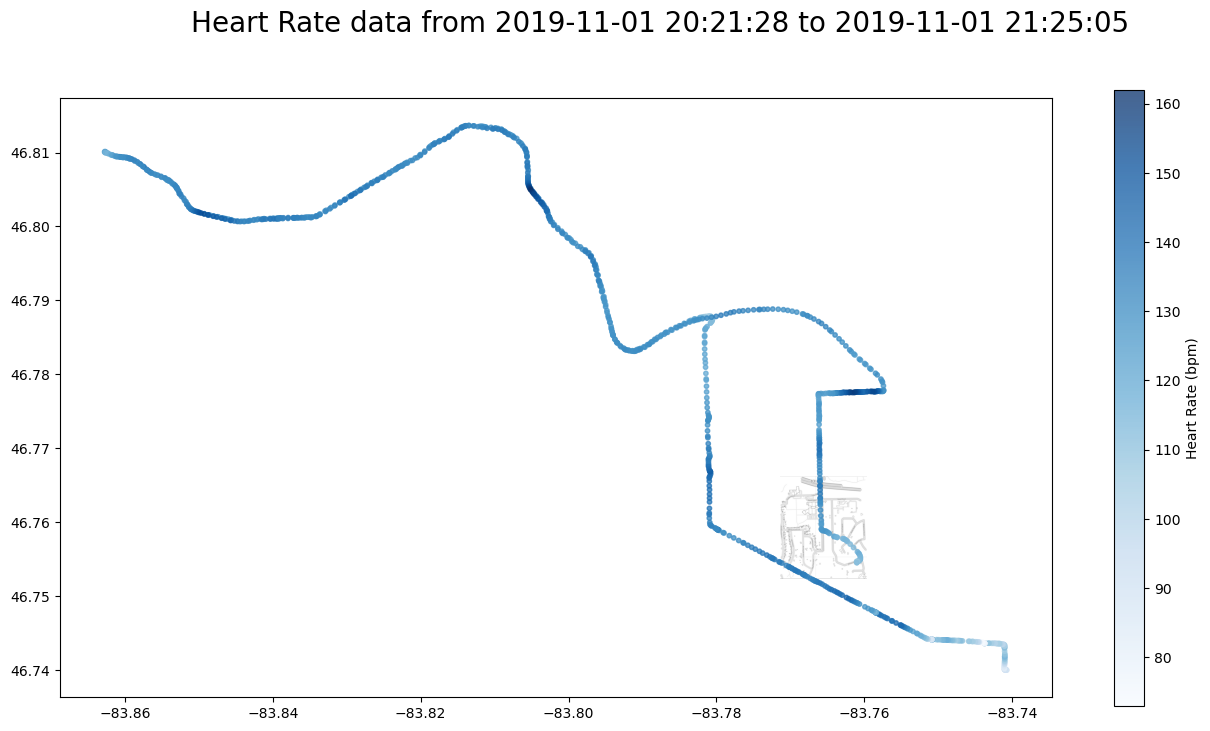

In [11]:
# Let's see the exact same code, but with all of the data points in it
plt.imshow(image, alpha=0.5, extent=[-83.77141,-83.75977,46.75230,46.76620])
plt.scatter(df["position_long_degrees"],df["position_lat_degrees_mercantor"],
            s=10, c=df["heart_rate"], cmap='Blues', alpha=0.75)
plt.colorbar().set_label("Heart Rate (bpm)")
plt.suptitle("Heart Rate data from {} to {}".format(np.min(small_df["timestamp"]),np.max(small_df["timestamp"])),size='20');

So now we get to see my whole cycling route, but we only have this tiny portion of the map.

An alternative approach taken for maps in web systems is to use tile server. Tile servers actually create a matrix of maps at different zoom levels, then serve up portions of a map (the tiles) as requested from the client. This is how Google Maps, for instance, works, and it creates a responsive experience at the cost of being a bit more fragile, as network access is needed. This paradigm is also available in the Jupyter notebooks as well, through a project called folium. This project is all client side JavaScript which does the map requesting and rendering. To connect this to our python backend we can use the folium project.

Be warned, this is a new library, so it takes us out of the matplotlib world, but I think you might find it is pretty natural if you need to map online plots.

In [12]:
# Let's import Folium
import folium
# Now let's render a spot from our previous data, for this we pick the center point of the map and a zoom level
m=folium.Map(location=[42.24,-83.764], zoom_start=12)
# A key eye will notice that I had to reverse our longitude and latitude for this library, *and* I'm not using
# the mercantor changed values for longitude. Welcome to geographical information systems!
display(m)

In [13]:
# Immediately you'll notice that the user experience is nice, and you can see that the data is being streamed
# by the OpenStreetMap project (lower right corner).

# We can add callouts to the map using the Marker class, let's set this for our start and end.
m=folium.Map(location=[42.296,-83.768], zoom_start=15)
folium.Marker([df["position_lat_degrees"].iloc[0],df["position_long_degrees"].iloc[0]], 
              popup="Start").add_to(m)
folium.Marker([df["position_lat_degrees"].iloc[-1],df["position_long_degrees"].iloc[-1]], 
              popup="Stop").add_to(m)

# We also want to map the whole cycling route. The docs for folium point to a PolyLine as the appropriate
# class to use. The PolyLine takes a list of locations as tuples, which means we have to combine our latiude
# and longitude values pairwise, and this is easily achieved through the use of python's zip() function
route=folium.PolyLine(locations=zip(df["position_lat_degrees"],df["position_long_degrees"]),
                    weight=5,color='blue').add_to(m)

# Let's take a look at that
display(m)

Wow! What a nice rendering. We can zoom and look around and get a nice interactive sense of our data. And
the docs really demonstrate how to use leaflet to do interesting things that have been well optimized in the
browser and JavaScript world, including setting colors through HTML codes and events. This is just the tip of
the iceberg when it comes to using folium, and I'd like to encourage you dive into those docs and play around
with it to learn more.

In this lecture I've just touched on some of the information mapping you can do mixing geographical
structures and data. We've seen several different approaches, from rendering a simple data plot superimposed
over a map in matplotlib, to drawing on top of a javascript based map with folium. Geographical Information Systems (GIS) are a big area,
but it's helpful to know a few things about spatial representation of data for those times when the physical
is a part of your investigation. 